In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the Ethereum Dataset
Ethereum = pd.read_csv('ETHUSD_1m_Coinbase.csv')

In [3]:
# Check the first few rows to ensure it loaded correctly
print(Ethereum.head())

             Open time    Low   High   Open  Close     Volume
0  2016-09-29 00:00:00  13.30  13.31  13.31  13.30    5.15493
1  2016-09-29 00:02:00  13.30  13.30  13.30  13.30    5.00000
2  2016-09-29 00:03:00  13.33  13.33  13.33  13.33    1.53755
3  2016-09-29 00:05:00  13.30  13.30  13.30  13.30    4.70303
4  2016-09-29 00:06:00  13.33  13.37  13.33  13.37  100.00000


In [4]:
# Hypothesis
print("\nHypothesis:")
print("Null Hypothesis: There is no significant relationship between historical Ethereum Ethereum and current Ethereum prices, with a prediction accuracy lower than 70%.")
print("Alternate Hypothesis: Historical Ethereum Ethereum significantly influences current Ethereum prices, enabling a predictive MLR model with an accuracy of 70% or higher.")


Hypothesis:
Null Hypothesis: There is no significant relationship between historical Ethereum Ethereum and current Ethereum prices, with a prediction accuracy lower than 70%.
Alternate Hypothesis: Historical Ethereum Ethereum significantly influences current Ethereum prices, enabling a predictive MLR model with an accuracy of 70% or higher.


In [5]:
# Data inspection
print("\nDataset Info:")
print(Ethereum.info())  # Check column types and missing values
print("\nSummary Statistics:")
print(Ethereum.describe())

# Check the number of rows and columns
num_rows, num_columns = Ethereum.shape
print("\nNumber of rows:", num_rows)
print("Number of columns:", num_columns)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144482 entries, 0 to 4144481
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Open time  object 
 1   Low        float64
 2   High       float64
 3   Open       float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(5), object(1)
memory usage: 189.7+ MB
None

Summary Statistics:
                Low          High          Open         Close        Volume
count  4.144482e+06  4.144482e+06  4.144482e+06  4.144482e+06  4.144482e+06
mean   1.299911e+03  1.301547e+03  1.300739e+03  1.300741e+03  1.251502e+02
std    1.204969e+03  1.206506e+03  1.205745e+03  1.205747e+03  2.715590e+02
min    1.000000e-01  5.930000e+00  5.920000e+00  5.920000e+00  1.000000e-08
25%    2.244500e+02  2.247000e+02  2.245800e+02  2.245800e+02  1.612940e+01
50%    8.967500e+02  8.990250e+02  8.980000e+02  8.980000e+02  4.889817e+01
75%    2.099600e+03  2.101860e+03  2.100740e+03  2.100730e+03  1.3006

In [6]:
# Check for duplicate rows
duplicates = Ethereum[Ethereum.duplicated()]

In [7]:
# Find rows with missing values
rows_with_missing = Ethereum[Ethereum.isnull().any(axis=1)]

In [8]:
# Print summary of duplicates and missing values
print(f"Number of duplicate rows: {len(duplicates)}")
print(f"Number of rows with missing values: {len(rows_with_missing)}")

Number of duplicate rows: 0
Number of rows with missing values: 0


In [9]:
# Calculate sparsity
total_elements = Ethereum.size
missing_elements = Ethereum.isnull().sum().sum()
sparsity = (missing_elements / total_elements) * 100

print("Data Sparsity (%):", sparsity)

Data Sparsity (%): 0.0


In [10]:
# Define a function to count outliers using IQR
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers.sum()

In [11]:
# Select numeric columns for outlier detection
numeric_columns = Ethereum.select_dtypes(include=['float64', 'int64'])

In [12]:
# Count outliers for each numeric column
count_outliers = numeric_columns.apply(count_outliers)

In [13]:
# Display the count of outliers
print(f"Number of outliers:")
print(count_outliers)

Number of outliers:
Low            0
High           0
Open           0
Close          0
Volume    400982
dtype: int64


Column: Volume
Lower Whisker: -154.7764581
Upper Whisker: 300.97249462
Count of Outliers: 400982


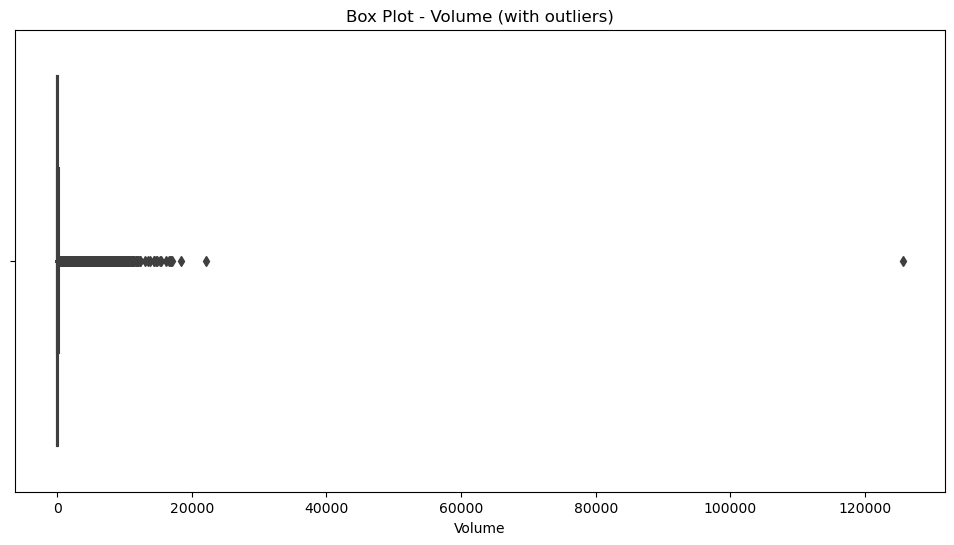

In [14]:
# Calculate descriptive statistics for 'Volume'
volume_stats = Ethereum['Volume'].describe()

# Identify outliers in the 'Volume' column
q1_volume = volume_stats['25%']
q3_volume = volume_stats['75%']
iqr_volume = q3_volume - q1_volume
lower_whisker_volume = q1_volume - 1.5 * iqr_volume
upper_whisker_volume = q3_volume + 1.5 * iqr_volume
outliers_volume = (Ethereum['Volume'] < lower_whisker_volume) | (Ethereum['Volume'] > upper_whisker_volume)

print(f"Column: Volume")
print(f"Lower Whisker: {lower_whisker_volume}")
print(f"Upper Whisker: {upper_whisker_volume}")
print(f"Count of Outliers: {outliers_volume.sum()}")

# Plot the boxplot for 'Volume'
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ethereum['Volume'])
plt.title('Box Plot - Volume (with outliers)')
plt.show()

In [15]:
# Display original data size
print(f"Original data size: {Ethereum.shape}")

Original data size: (4144482, 6)


In [16]:
# Remove outliers where 'Volume' exceeds 1500
Ethereum_cleaned = Ethereum[Ethereum['Volume'] <= 1500]

# Display cleaned data size
print(f"Cleaned data size: {Ethereum_cleaned.shape}")

# Verify if outliers were removed
print(Ethereum_cleaned['Volume'].describe())

Cleaned data size: (4119926, 6)
count    4.119926e+06
mean     1.114571e+02
std      1.753711e+02
min      1.000000e-08
25%      1.599960e+01
50%      4.835247e+01
75%      1.275914e+02
max      1.500000e+03
Name: Volume, dtype: float64


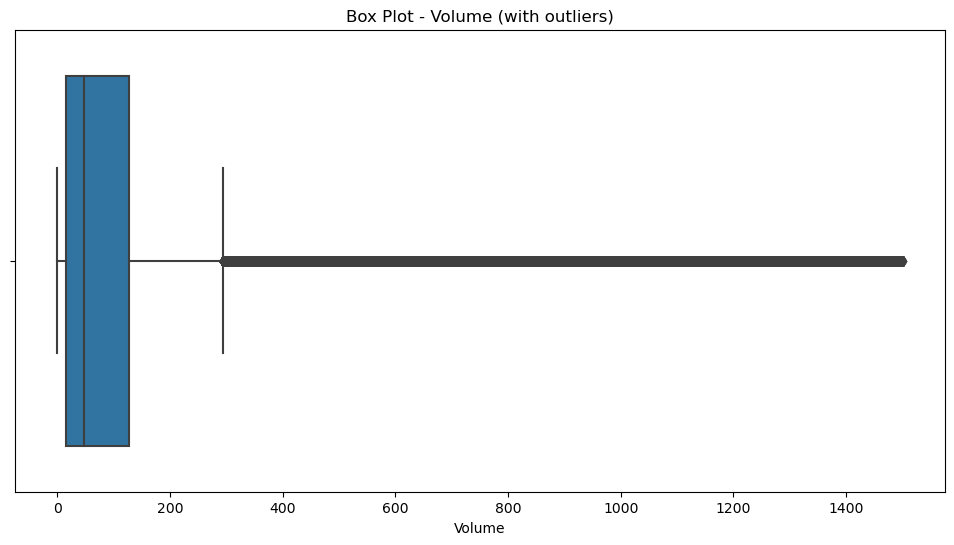

In [17]:
# Plot the boxplot for 'Volume'
plt.figure(figsize=(12, 6))
sns.boxplot(x=Ethereum_cleaned['Volume'])
plt.title('Box Plot - Volume (with outliers)')
plt.show()

In [18]:
# Write the DataFrame to a CSV file
Ethereum_cleaned.to_csv('cleaned_data.csv')

In [19]:
# Define target and features
target = 'Close'
features = ['Open', 'High', 'Low', 'Volume']

In [20]:
# Define the feature matrix X and target vector y
X = Ethereum_cleaned[features]
y = Ethereum_cleaned[target]

In [21]:
# Summary statistics for X
summary_X = X.describe(include='all')
print("Summary statistics for X:")
print(summary_X)

# Summary statistics for Y
summary_Y = y.describe()
print("\nSummary statistics for Y:")
print(summary_Y)

Summary statistics for X:
               Open          High           Low        Volume
count  4.119926e+06  4.119926e+06  4.119926e+06  4.119926e+06
mean   1.302737e+03  1.303526e+03  1.301935e+03  1.114571e+02
std    1.206754e+03  1.207506e+03  1.205993e+03  1.753711e+02
min    5.920000e+00  5.930000e+00  5.910000e+00  1.000000e-08
25%    2.248000e+02  2.249000e+02  2.246800e+02  1.599960e+01
50%    9.129850e+02  9.140000e+02  9.116000e+02  4.835247e+01
75%    2.105440e+03  2.106767e+03  2.104260e+03  1.275914e+02
max    4.864970e+03  4.867810e+03  4.863000e+03  1.500000e+03

Summary statistics for Y:
count    4.119926e+06
mean     1.302743e+03
std      1.206759e+03
min      5.920000e+00
25%      2.248000e+02
50%      9.129800e+02
75%      2.105440e+03
max      4.864970e+03
Name: Close, dtype: float64


In [22]:
# Fit the OLS model
model = sm.OLS(y, sm.add_constant(X)).fit()

In [23]:
# Display the summary of the initial OLS model
print("Initial Model Summary for Ethereum Data:")
print(model.summary())

Initial Model Summary for Ethereum Data:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.308e+12
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:53:30   Log-Likelihood:            -4.9584e+06
No. Observations:             4119926   AIC:                         9.917e+06
Df Residuals:                 4119921   BIC:                         9.917e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [24]:
# Residual standard error
residual_std_error_initial = model.scale
print("\nResidual Standard Error (Initial Model):", round(residual_std_error_initial, 2))

# Regression equation for the initial model
print("\nRegression Equation for Initial Model:")
equation_components_initial = [f"{model.params['const']:.2f} (Intercept)"]
for feature in model.params.index[1:]:  # Exclude the intercept
    equation_components_initial.append(f"{model.params[feature]:.2f}*{feature}")
equation_initial = " + ".join(equation_components_initial) + f" + {round(residual_std_error_initial, 2)} (Error)"
print(equation_initial)


Residual Standard Error (Initial Model): 0.65

Regression Equation for Initial Model:
0.00 (Intercept) + -0.53*Open + 0.78*High + 0.75*Low + 0.00*Volume + 0.65 (Error)


In [25]:
# Calculate VIF for all variables
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF for all variables
print("\nVariance Inflation Factor (VIF) for All Features:")
print(vif)


Variance Inflation Factor (VIF) for All Features:
  Features           VIF
0     Open  2.662055e+06
1     High  1.725758e+06
2      Low  1.728278e+06
3   Volume  1.541857e+00


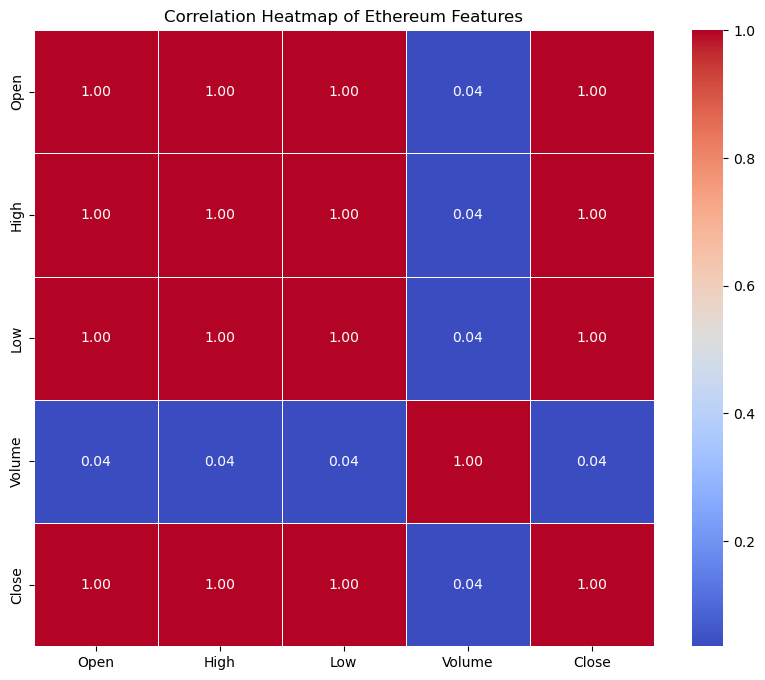

In [26]:
# Correlation Heatmap
correlation_matrix = Ethereum_cleaned[features + [target]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Ethereum Features')
plt.show()

In [27]:
# Normality Testing for each feature and target using Shapiro-Wilk test
normality_results = {}
for column in features + [target]:
    # Randomly sample up to 5000 rows
    sample = Ethereum_cleaned[column].dropna()
    if len(sample) > 5000:
        sample = sample.sample(5000, random_state=42)
    
    stat, p_value = stats.shapiro(sample)
    normality_results[column] = {'stat': stat, 'p-value': p_value}

# Display results
for col, result in normality_results.items():
    print(f"{col}: Statistic={result['stat']:.3f}, p-value={result['p-value']:6e}")

Open: Statistic=0.879, p-value=0.000000e+00
High: Statistic=0.879, p-value=0.000000e+00
Low: Statistic=0.879, p-value=0.000000e+00
Volume: Statistic=0.610, p-value=0.000000e+00
Close: Statistic=0.879, p-value=0.000000e+00


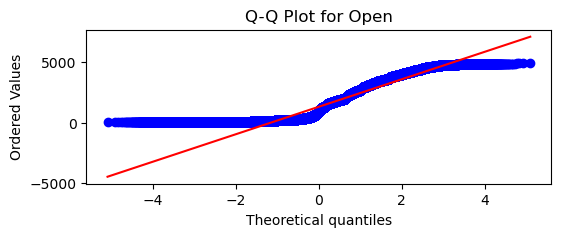

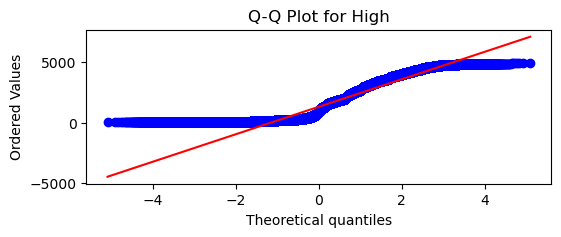

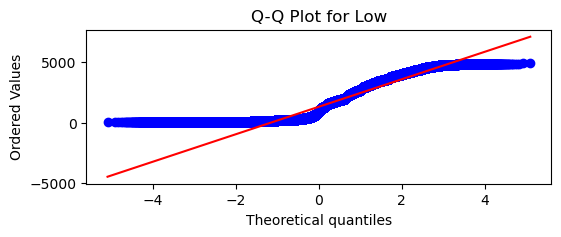

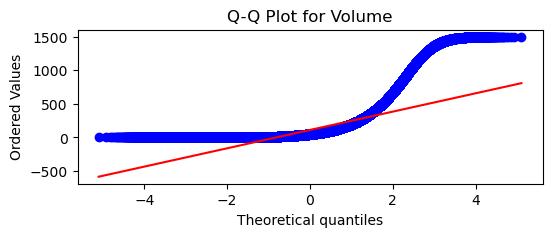

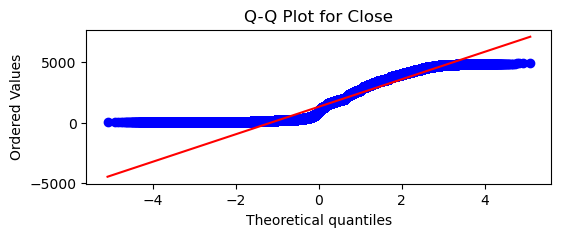

In [52]:
# Q-Q plots for each predictor
for column in features + [target]:
    plt.figure(figsize=(6, 2))
    stats.probplot(Ethereum_cleaned[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.show()

In [29]:
# Display the initial model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.308e+12
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:54:46   Log-Likelihood:            -4.9584e+06
No. Observations:             4119926   AIC:                         9.917e+06
Df Residuals:                 4119921   BIC:                         9.917e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      4.986      0.0

In [30]:
# Stepwise feature selection (removing features with p-value > 0.05)
high_pvalue_features = ['Volume']
X_reduced_pvalue = X.drop(high_pvalue_features, axis=1)

In [31]:
# Refit the model with the remaining features
reduced_model = sm.OLS(y, sm.add_constant(X_reduced_pvalue)).fit()

print(f"\nRemoved Volume due to high p-value. New model summary:")
print(reduced_model.summary())


Removed Volume due to high p-value. New model summary:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.077e+12
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:54:48   Log-Likelihood:            -4.9584e+06
No. Observations:             4119926   AIC:                         9.917e+06
Df Residuals:                 4119922   BIC:                         9.917e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [32]:
# Remove the 'Volume' feature from X
X_no_volume = X.drop(columns=['Volume'])

# Calculate VIF for all variables except 'Volume'
vif = pd.DataFrame()
vif["Features"] = X_no_volume.columns
vif["VIF"] = [variance_inflation_factor(X_no_volume.values, i) for i in range(X_no_volume.shape[1])]

# Print VIF for all remaining variables
print("\nVariance Inflation Factor (VIF) for All Features (without 'Volume'):")
print(vif)


Variance Inflation Factor (VIF) for All Features (without 'Volume'):
  Features           VIF
0     Open  2.661659e+06
1     High  1.504365e+06
2      Low  1.488264e+06


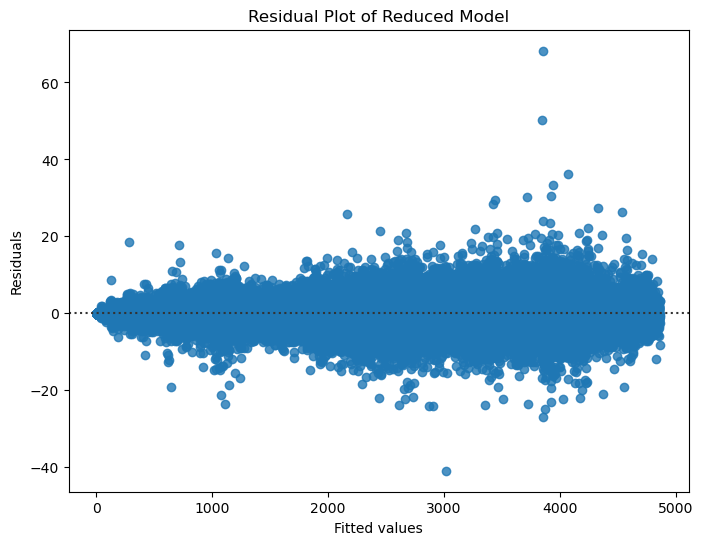

In [33]:
# Residual plot
# Homoscedasticity: Residuals vs. Fitted Values
plt.figure(figsize=(8, 6))
sns.residplot(x=reduced_model.fittedvalues, y=reduced_model.resid)
plt.title('Residual Plot of Reduced Model')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [34]:
# Residual standard error
residual_std_error_reduced = reduced_model.scale
print("\nResidual Standard Error (Reduced Model):", round(residual_std_error_reduced, 2))

# Regression equation for the reduced model
print("\nRegression Equation for Reduced Model:")
equation_components_reduced = [f"{model.params['const']:.2f} (Intercept)"]
for feature in reduced_model.params.index[1:]:  # Exclude the intercept
    equation_components_reduced.append(f"{reduced_model.params[feature]:.2f}*{feature}")
equation_reduced = " + ".join(equation_components_reduced) + f" + {round(residual_std_error_reduced, 2)} (Error)"
print(equation_reduced)


Residual Standard Error (Reduced Model): 0.65

Regression Equation for Reduced Model:
0.00 (Intercept) + -0.53*Open + 0.78*High + 0.75*Low + 0.65 (Error)


In [35]:
# Interpreting coefficients
coefficients_red = pd.DataFrame({'Feature': reduced_model.params.index, 'Coefficient': reduced_model.params.values})
print("\nRegression Coefficients:")
print(coefficients_red)

# Explain the most influential features
top_features = coefficients_red.sort_values(by='Coefficient', key=abs, ascending=False)
print("\nMost Influential Features:")
print(top_features.head())


Regression Coefficients:
  Feature  Coefficient
0   const     0.003658
1    Open    -0.531532
2    High     0.782292
3     Low     0.749229

Most Influential Features:
  Feature  Coefficient
2    High     0.782292
3     Low     0.749229
1    Open    -0.531532
0   const     0.003658


In [36]:
# Interpretation of the coefficients
print("\nInterpretation of Coefficients:")
for feature, coefficient_red in reduced_model.params.items():
    if feature != 'const':  # Exclude the intercept
        if coefficient_red > 0:
            print(f"The coefficient of {feature} is {coefficient_red:.2f}, indicating that for each unit increase in {feature}, the target variable (Close price) increases by {coefficient_red:.2f} units.")
        elif coefficient_red < 0:
            print(f"The coefficient of {feature} is {coefficient_red:.2f}, indicating that for each unit increase in {feature}, the target variable (Close price) decreases by {coefficient_red:.2f} units.")
        else:
            print(f"The coefficient of {feature} is {coefficient_red:.2f}, indicating that changes in {feature} have no effect on the target variable (Close price).")


Interpretation of Coefficients:
The coefficient of Open is -0.53, indicating that for each unit increase in Open, the target variable (Close price) decreases by -0.53 units.
The coefficient of High is 0.78, indicating that for each unit increase in High, the target variable (Close price) increases by 0.78 units.
The coefficient of Low is 0.75, indicating that for each unit increase in Low, the target variable (Close price) increases by 0.75 units.


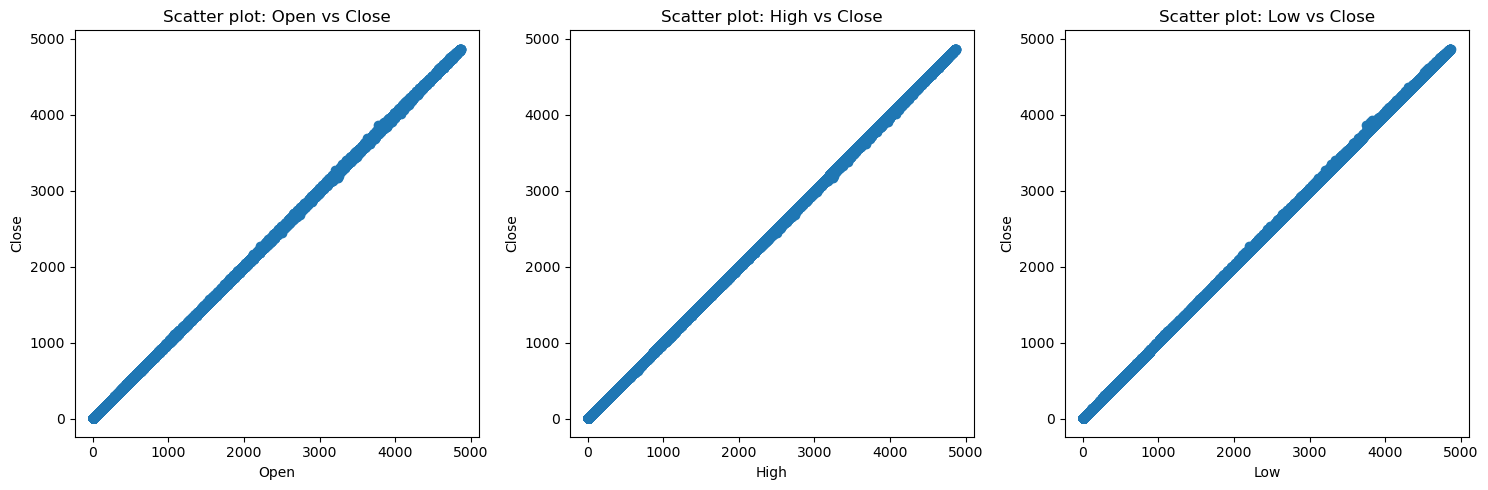

In [37]:
# Scatter plots for testing linearity between predictors and Close
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X['Open'], y)
plt.title('Scatter plot: Open vs Close')
plt.xlabel('Open')
plt.ylabel('Close')

plt.subplot(1, 3, 2)
plt.scatter(X['High'], y)
plt.title('Scatter plot: High vs Close')
plt.xlabel('High')
plt.ylabel('Close')

plt.subplot(1, 3, 3)
plt.scatter(X['Low'], y)
plt.title('Scatter plot: Low vs Close')
plt.xlabel('Low')
plt.ylabel('Close')

plt.tight_layout()
plt.show()

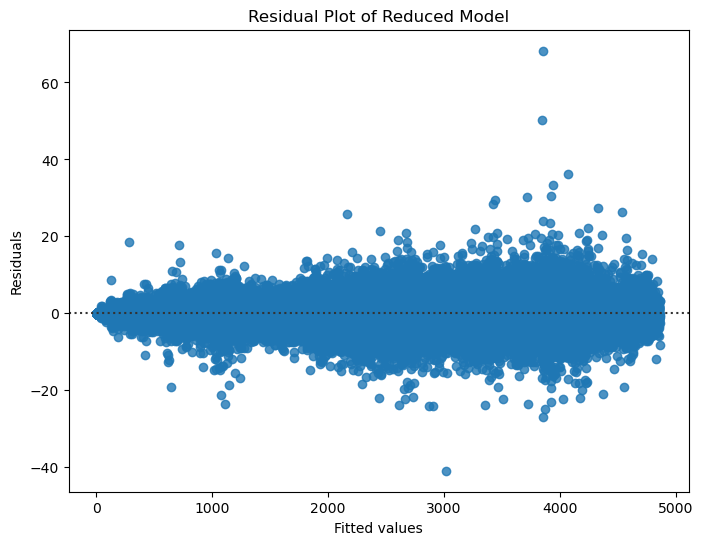

In [38]:
# Calculate residuals and fitted values from the statsmodels linear regression model
residuals_reduced = reduced_model.resid  # Residuals from the model
fitted_values = reduced_model.fittedvalues  # Fitted (predicted) values from the model

# Residual plot for homoscedasticity check
plt.figure(figsize=(8, 6))
sns.residplot(x=fitted_values, y=residuals_reduced, lowess=False, line_kws={'color': 'red'})
plt.title('Residual Plot of Reduced Model')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

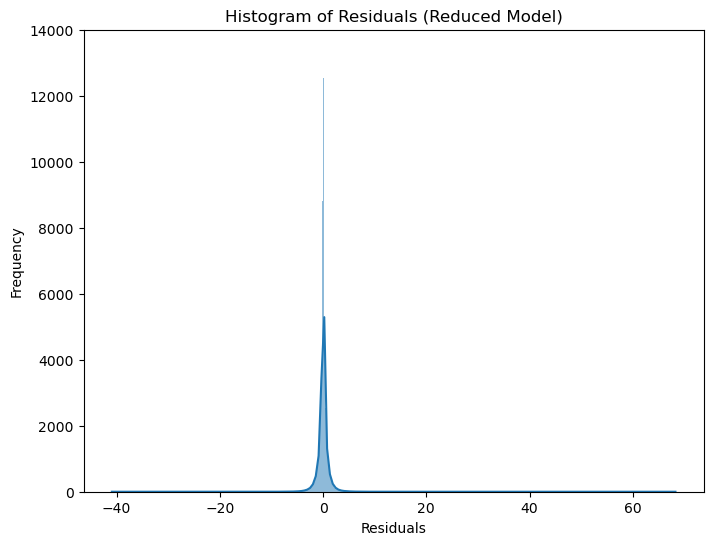

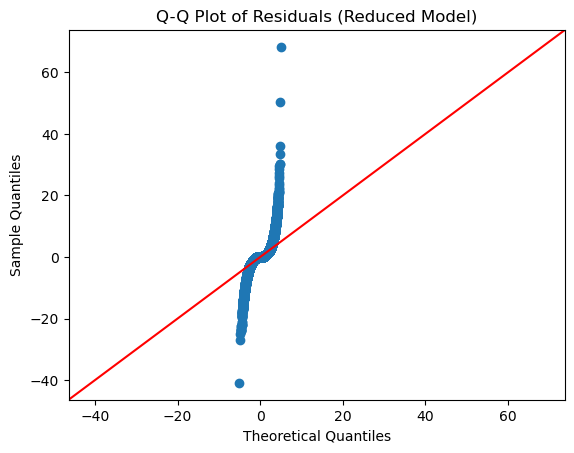

In [39]:
# Histogram for normality of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_reduced, kde=True)
plt.title('Histogram of Residuals (Reduced Model)')
plt.ylim(0, 14000)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot for normality of residuals
sm.qqplot(residuals_reduced, line='45')
plt.title('Q-Q Plot of Residuals (Reduced Model)')
plt.show()

In [40]:
# Model Evaluation Metrics
# R-squared and Adjusted R-squared for the reduced model
r_squared_reduced = reduced_model.rsquared
adj_r_squared_reduced = reduced_model.rsquared_adj

# Compute RMSE for the reduced model
rmse_reduced = np.sqrt(mean_squared_error(y, reduced_model.fittedvalues))

# Display model evaluation metrics
print(f"R-squared: {r_squared_reduced:.4f}")
print(f"Adjusted R-squared: {adj_r_squared_reduced:.4f}")
print(f"RMSE: {rmse_reduced:.4f}")

R-squared: 1.0000
Adjusted R-squared: 1.0000
RMSE: 0.8062


In [41]:
# Check p-values for the reduced model
print("P-values for the reduced model:")
print(reduced_model.pvalues)

P-values for the reduced model:
const    3.907787e-10
Open     0.000000e+00
High     0.000000e+00
Low      0.000000e+00
dtype: float64


In [42]:
# Initial model R-squared and RMSE
r_squared_initial = model.rsquared
rmse_initial = np.sqrt(mean_squared_error(y, model.fittedvalues))

# Comparison summary
print("Model Comparison:")
print(f"Initial Model - R-squared: {r_squared_initial:.4f}, RMSE: {rmse_initial:.4f}")
print(f"Reduced Model - R-squared: {r_squared_reduced:.4f}, RMSE: {rmse_reduced:.4f}")

Model Comparison:
Initial Model - R-squared: 1.0000, RMSE: 0.8062
Reduced Model - R-squared: 1.0000, RMSE: 0.8062


In [43]:
# Ensure 'Ethereum_cleaned' is a proper copy or slice
Ethereum_cleaned = Ethereum_cleaned.copy()  # if it was a subset of another dataframe

# Convert 'Open time' to datetime
Ethereum_cleaned.loc[:, 'Date'] = pd.to_datetime(Ethereum_cleaned['Open time'])

# Extract the day of the week and create a new column 'DayOfWeek'
Ethereum_cleaned.loc[:, 'DayOfWeek'] = Ethereum_cleaned['Date'].dt.day_name()

# Verify the result
print(Ethereum_cleaned[['Date', 'DayOfWeek']].head())

                 Date DayOfWeek
0 2016-09-29 00:00:00  Thursday
1 2016-09-29 00:02:00  Thursday
2 2016-09-29 00:03:00  Thursday
3 2016-09-29 00:05:00  Thursday
4 2016-09-29 00:06:00  Thursday


In [44]:
# Perform ANOVA for day-of-week effect on Ethereum prices
days_of_week = [Ethereum_cleaned[Ethereum_cleaned['DayOfWeek'] == day][target] for day in Ethereum_cleaned['DayOfWeek'].unique()]
anova_result = f_oneway(*days_of_week)

print(f"ANOVA Results: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

ANOVA Results: F-statistic = 10.00693535390813, p-value = 4.4150923172678115e-11


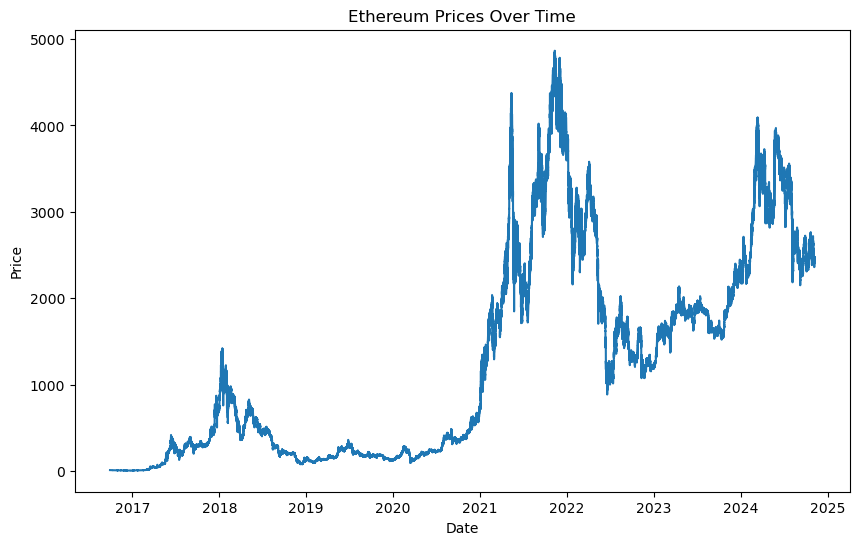

In [45]:
# Time Series Plots for Ethereum Prices
plt.figure(figsize=(10, 6))
plt.plot(Ethereum_cleaned['Date'], Ethereum_cleaned[target])
plt.title('Ethereum Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

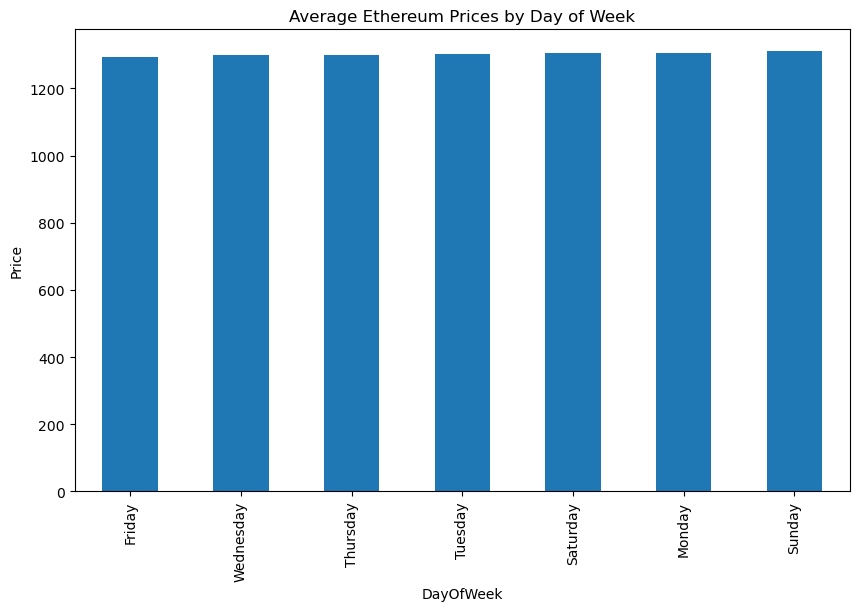

In [46]:
# Stacked bar charts for day-of-week effect on Ethereum prices
day_of_week_prices = Ethereum_cleaned.groupby('DayOfWeek')[target].mean().sort_values()

plt.figure(figsize=(10, 6))
day_of_week_prices.plot(kind='bar', stacked=True)
plt.title('Average Ethereum Prices by Day of Week')
plt.ylabel('Price')
plt.show()

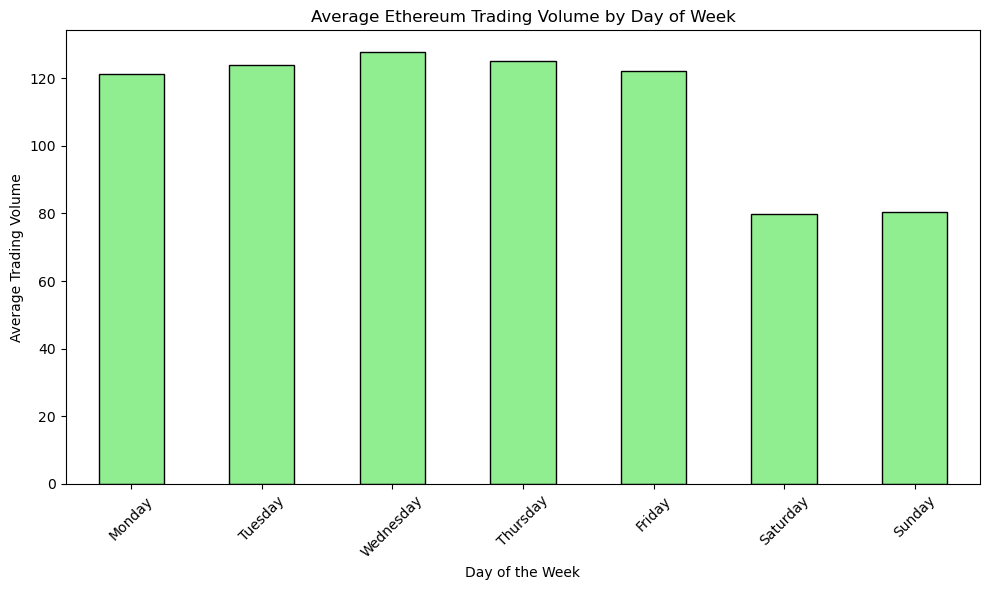

In [47]:
# Stacked bar charts for day-of-week effect on Ethereum Volume of sales
# Ensure the days are in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_prices = day_of_week_prices.reindex(day_order)

day_of_week_volume = Ethereum_cleaned.groupby('DayOfWeek')['Volume'].mean()
day_of_week_volume = day_of_week_volume.reindex(day_order)

plt.figure(figsize=(10, 6))
day_of_week_volume.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average Ethereum Trading Volume by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trading Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

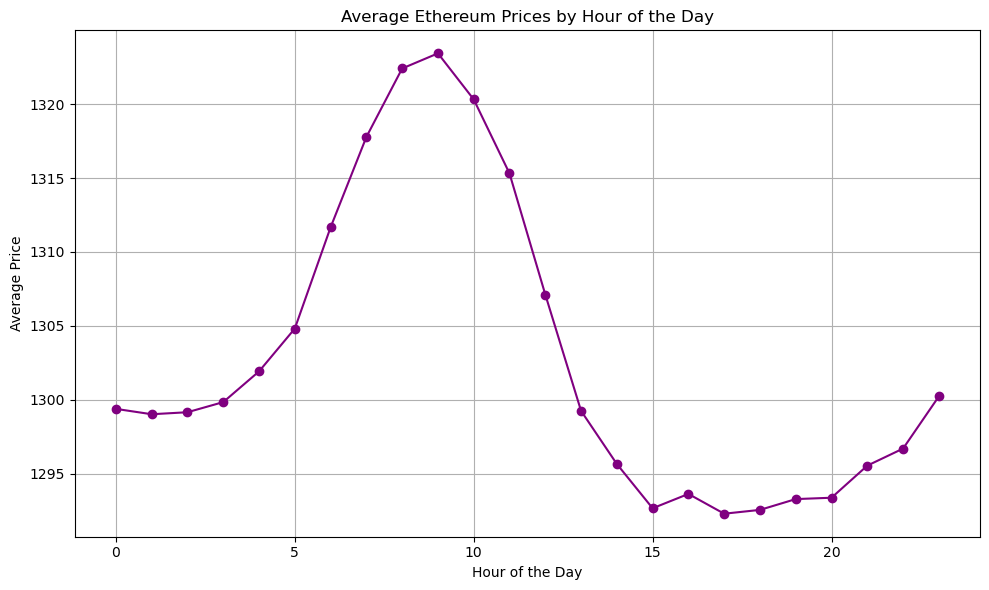

In [48]:
# Extract the hour from the 'Date' column
Ethereum_cleaned.loc[:, 'Hour'] = Ethereum_cleaned['Date'].dt.hour

# Group by hour and calculate the mean of the target column
hourly_prices = Ethereum_cleaned.groupby('Hour')[target].mean()

# Plot the hourly patterns
plt.figure(figsize=(10, 6))
hourly_prices.plot(kind='line', color='purple', marker='o')
plt.title('Average Ethereum Prices by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Price')
plt.grid()
plt.tight_layout()
plt.show()

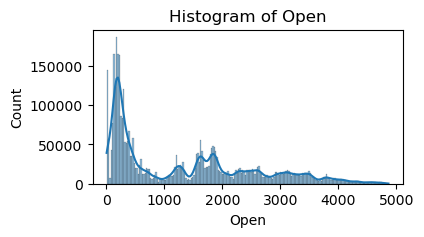

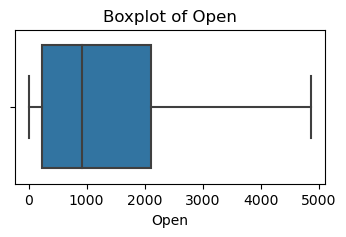

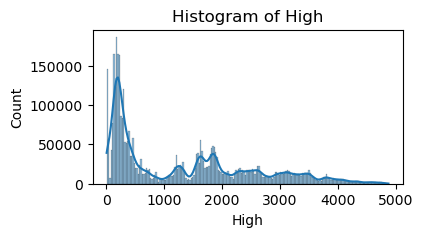

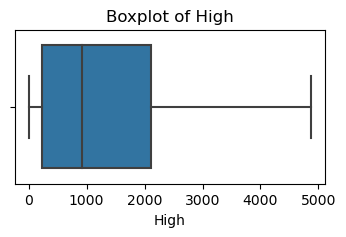

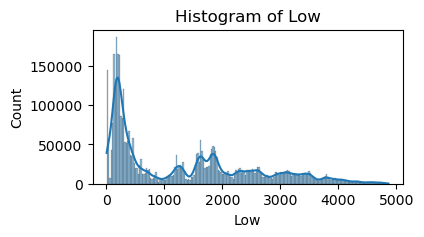

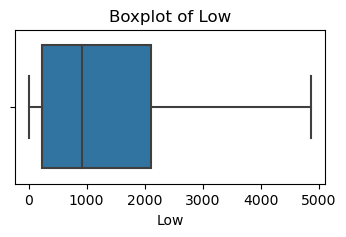

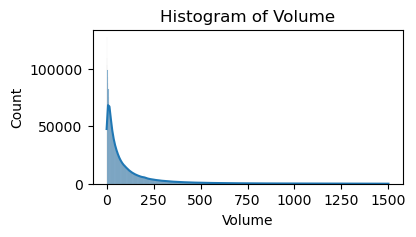

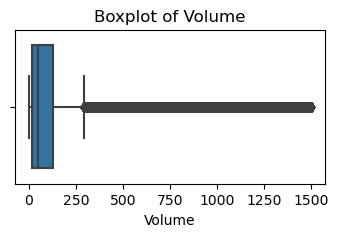

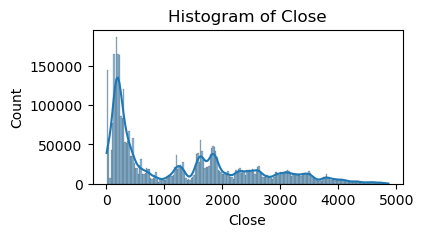

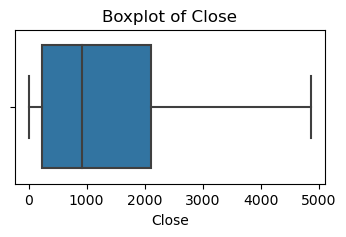

In [55]:
# Variable Distribution: Histograms and Boxplots
for column in features + [target]:
    plt.figure(figsize=(4, 2))
    sns.histplot(Ethereum_cleaned[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

    plt.figure(figsize=(4, 2))
    sns.boxplot(x=Ethereum_cleaned[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [50]:
# Set a threshold for prediction accuracy (e.g., 70%)
threshold = 0.7

# Print out the R-squared value for transparency
print(f"R-squared value: {adj_r_squared_reduced:.2f}")

# Decision logic
if adj_r_squared_reduced >= threshold:
    print("\nDecision: Reject the null hypothesis and accept the alternative hypothesis.")
    print("Reason: The model demonstrates a significant relationship between historical Ethereum data and current Ethereum prices, achieving the desired prediction accuracy.")
    print("\nConclusion: Historical Ethereum data significantly influences current Ethereum prices, supporting the alternative hypothesis that the predictive model achieves at least 70% accuracy.")
else:
    print("\nDecision: Fail to reject the null hypothesis and reject the alternative hypothesis.")
    print("Reason: The model does not achieve the desired prediction accuracy, indicating no significant relationship between historical Ethereum data and current Ethereum prices.")
    print("\nConclusion: Historical Ethereum data does not significantly influence current Ethereum prices, suggesting that the model is not reliable for making predictions with at least 70% accuracy.")

R-squared value: 1.00

Decision: Reject the null hypothesis and accept the alternative hypothesis.
Reason: The model demonstrates a significant relationship between historical Ethereum data and current Ethereum prices, achieving the desired prediction accuracy.

Conclusion: Historical Ethereum data significantly influences current Ethereum prices, supporting the alternative hypothesis that the predictive model achieves at least 70% accuracy.
